<a href="https://colab.research.google.com/github/JD-TEK/CS6800-Final-Project/blob/main/CS6800Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
#Import required libraries
import keras
keras.__version__
from keras import models, layers
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
import datetime
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Load Bitcoin pricing dataset
btc = pd.read_csv('/content/gdrive/My Drive/Colab/btc/btc_raw.csv')
btc['Timestamp'] = pd.to_datetime(btc['Timestamp'])
btc = btc.set_index('Timestamp')
print(btc.shape)
btc.head()

(63024, 4)


,Volume_(Currency),Volume_(BTC),Midprice,Close
Timestamp,,,,
2011-12-31 17:00:00,41.220000,9.000000,4.580,4.58
2012-01-04 16:00:00,73.060000,13.629423,5.365,5.37
2012-01-06 18:00:00,63.677519,9.949612,6.400,6.40
2012-01-09 16:00:00,40.000000,6.060606,6.600,6.60
2012-01-10 10:00:00,14.120000,2.237179,6.320,6.24


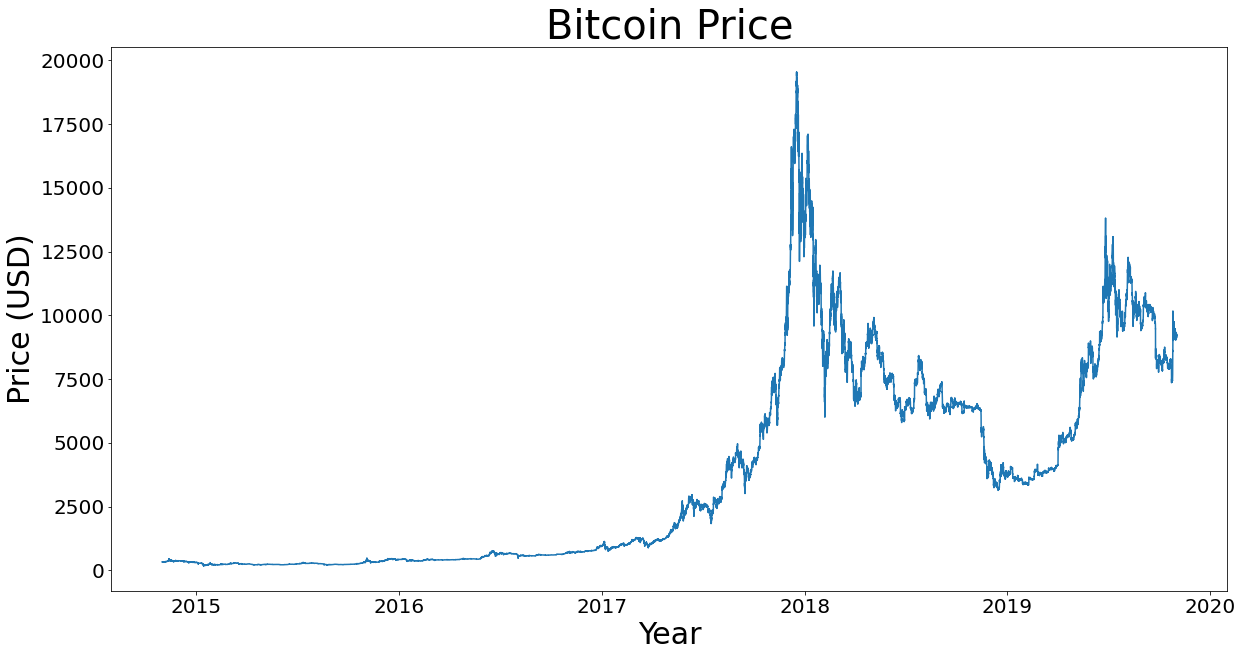

In [4]:
# Visualize Data
# Select correct time window
btc = btc.loc['2014-11-01':'2019-11-01']
plt.figure(figsize=(20,10))
plt.plot(btc["Close"])
plt.title('Bitcoin Price',fontsize=40)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Price (USD)',fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

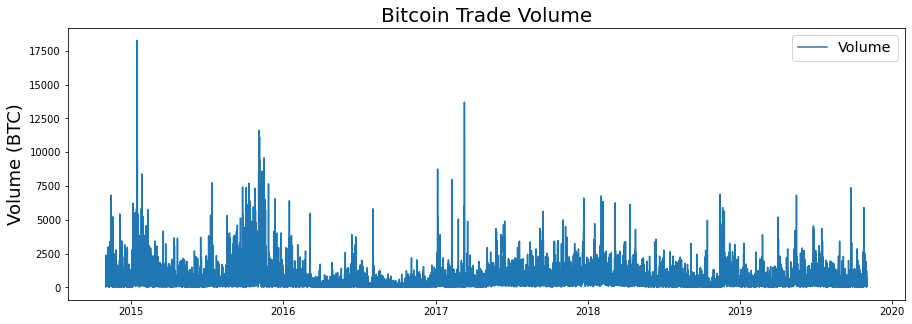

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(btc['Volume_(BTC)'])
plt.ylabel('Volume (BTC)', fontsize=18)
plt.title("Bitcoin Trade Volume", fontsize=20)
plt.legend(['Volume'], fontsize='x-large', loc='best')
plt.show()

In [6]:
# Load and check Reddit dataset
reddit_num = pd.read_csv('/content/gdrive/My Drive/Colab/btc/reddit_num.csv')
reddit_num['Timestamp'] = pd.to_datetime(reddit_num['Timestamp'])
reddit_num = reddit_num.set_index('Timestamp')
print(reddit_num.shape)
reddit_num.head()

(43848, 1)


,Reddits
Timestamp,
2014-11-01 00:00:00,97.0
2014-11-01 01:00:00,54.0
2014-11-01 02:00:00,34.0
2014-11-01 03:00:00,65.0
2014-11-01 04:00:00,111.0


In [7]:
# Load and check Twitter dataset
tweets = pd.read_csv('/content/gdrive/My Drive/Colab/btc/tweets_num.csv')
tweets['Timestamp'] = pd.to_datetime(tweets['Timestamp'])
tweets = tweets.set_index('Timestamp')
tweets.columns = ['Tweets']
# check for nan
tweets = tweets.dropna()
tweets.isnull().sum()
print(tweets.shape)
tweets.head()

(43848, 1)


,Tweets
Timestamp,
2014-11-01 00:00:00,6
2014-11-01 01:00:00,7
2014-11-01 02:00:00,8
2014-11-01 03:00:00,7
2014-11-01 04:00:00,8


In [8]:
# Merge all datasets in to one
result = pd.merge(reddit_num, btc, how='inner', on='Timestamp')
results = pd.merge(result, tweets, how='inner', on='Timestamp')
print(results.shape)
results.head()

(38115, 6)


,Reddits,Volume_(Currency),Volume_(BTC),Midprice,Close,Tweets
Timestamp,,,,,,
2014-11-01 00:00:00,97.0,58214.419214,171.957335,338.550889,337.99,6
2014-11-01 01:00:00,54.0,44021.945447,130.013344,338.942941,339.00,7
2014-11-01 02:00:00,34.0,16629.064688,49.138989,338.754500,338.50,8
2014-11-01 03:00:00,65.0,8784.442248,25.906093,339.162500,338.62,7
2014-11-01 04:00:00,111.0,27228.992384,80.307481,339.196364,339.34,8


In [9]:
# check for nan
#result = result.dropna()
results.isnull().sum()

Reddits              0
Volume_(Currency)    0
Volume_(BTC)         0
Midprice             0
Close                0
Tweets               0
dtype: int64

In [10]:
del results['Volume_(Currency)']
del results['Midprice']
results = results[['Close','Reddits', 'Tweets','Volume_(BTC)']]
results.columns = ['Close', 'Reddits', 'Tweets', 'Volume']
print(results.shape)
results.head()

(38115, 4)


,Close,Reddits,Tweets,Volume
Timestamp,,,,
2014-11-01 00:00:00,337.99,97.0,6,171.957335
2014-11-01 01:00:00,339.00,54.0,7,130.013344
2014-11-01 02:00:00,338.50,34.0,8,49.138989
2014-11-01 03:00:00,338.62,65.0,7,25.906093
2014-11-01 04:00:00,339.34,111.0,8,80.307481


In [11]:
# Detecting outliers
def detect(signal, treshold = 1.4):
    detected = []
    for i in range(len(signal)):
        if np.abs(signal[i]) > treshold:
            detected.append(i)
    return detected

In [12]:
signal = np.copy(results['Close'].values)
std_signal = (signal - np.mean(signal)) / np.std(signal)
s = pd.Series(std_signal)
s.describe(percentiles = [0.25, 0.5, 0.75, 0.95])

count    3.811500e+04
mean     1.300168e-15
std      1.000013e+00
min     -9.868729e-01
25%     -9.206161e-01
50%     -1.888003e-01
75%      7.359914e-01
95%      1.771351e+00
max      3.858788e+00
dtype: float64

In [13]:
outliers = detect(std_signal, 1.4)

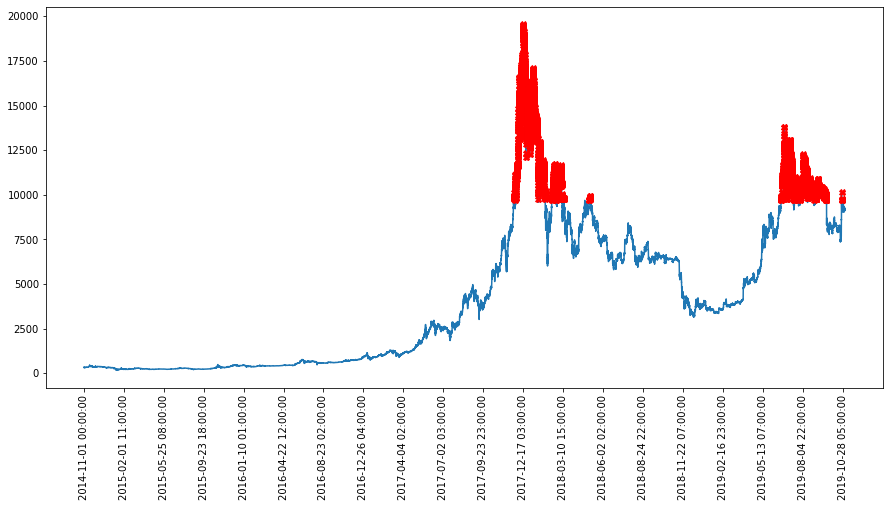

In [14]:
plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(signal)), signal)
plt.plot(
    np.arange(len(signal)),
    signal,
    'X',
    label = 'outliers',
    markevery = outliers,
    c = 'r',
)
plt.xticks(
    np.arange(len(signal))[::2000], results.index[::2000], rotation = 'vertical'
)
plt.show()

In [15]:
# Normalise all data values using minmax scaler
minmax = MinMaxScaler().fit(results[['Reddits', 'Tweets', 'Close','Volume']])
scaled = minmax.transform(results[['Reddits', 'Tweets', 'Close', 'Volume']])

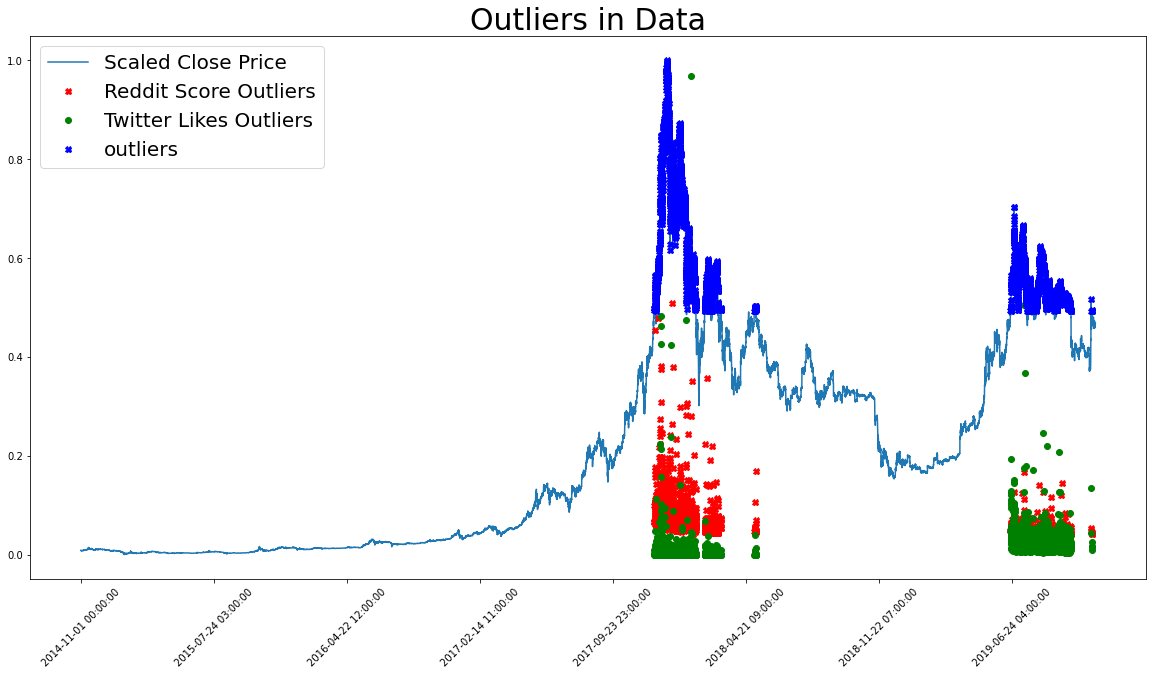

In [16]:
plt.figure(figsize = (20, 10))
plt.title("Outliers in Data", fontsize=30)
#plt.plot(np.arange(len(signal)), scaled[:, 0], label = 'Scaled score')
#plt.plot(np.arange(len(signal)), scaled[:, 1], label = 'Scaled likes')
plt.plot(np.arange(len(signal)), scaled[:, 2], label = 'Scaled Close Price')
#plt.plot(np.arange(len(signal)), scaled[:, 3], label = 'Scaled Volume BTC')
plt.plot(
    np.arange(len(signal)),
    scaled[:, 0],
    'X',
    label = 'Reddit Score Outliers',
    markevery = outliers,
    c = 'r',
)
plt.plot(
    np.arange(len(signal)),
    scaled[:, 1],
    'o',
    label = 'Twitter Likes Outliers',
    markevery = outliers,
    c = 'g',
)
plt.plot(
    np.arange(len(signal)),
    scaled[:,2],
    'X',
    label = 'outliers',
    markevery = outliers,
    c = 'b',
)
plt.xticks(
    np.arange(len(signal))[::5000], results.index[::5000], rotation = 45
)
plt.legend(fontsize=20)
plt.show()

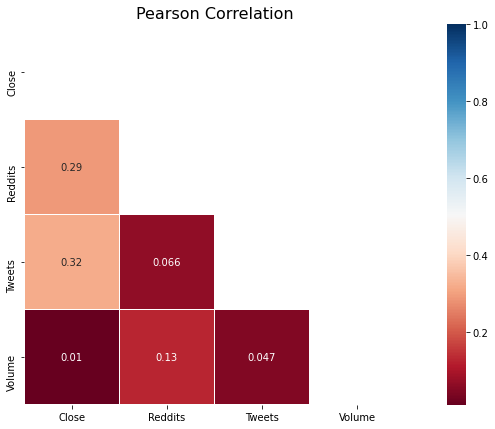

In [17]:
# Plot correlations between datasets
colormap = plt.cm.RdBu
plt.figure(figsize = (15, 7))
plt.title('Pearson Correlation', y = 1, size = 16)

mask = np.zeros_like(results.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    results.corr(),
    mask = mask,
    linewidths = 0.1,
    vmax = 1.0,
    square = True,
    cmap = colormap,
    linecolor = 'white',
    annot = True,
)
plt.show()

In [18]:
df = results.reset_index()
df

,Timestamp,Close,Reddits,Tweets,Volume
0,2014-11-01 00:00:00,337.99,97.0,6,171.957335
1,2014-11-01 01:00:00,339.00,54.0,7,130.013344
2,2014-11-01 02:00:00,338.50,34.0,8,49.138989
3,2014-11-01 03:00:00,338.62,65.0,7,25.906093
4,2014-11-01 04:00:00,339.34,111.0,8,80.307481
...,...,...,...,...,...
38110,2019-11-01 19:00:00,9203.02,319.0,5904,127.703055
38111,2019-11-01 20:00:00,9189.38,185.0,4087,109.077034
38112,2019-11-01 21:00:00,9205.63,125.0,12210,162.508616
38113,2019-11-01 22:00:00,9267.30,153.0,5526,149.032780


In [19]:
# Define and plot moving averages
def moving_average(signal, period):
    buffer = [np.nan] * period
    for i in range(period, len(signal)):
        buffer.append(signal[i - period : i].mean())
    return buffer

In [20]:
signal = np.copy(df['Close'].values)
ma_7 = moving_average(signal, 7)
ma_14 = moving_average(signal, 14)
ma_30 = moving_average(signal, 30)

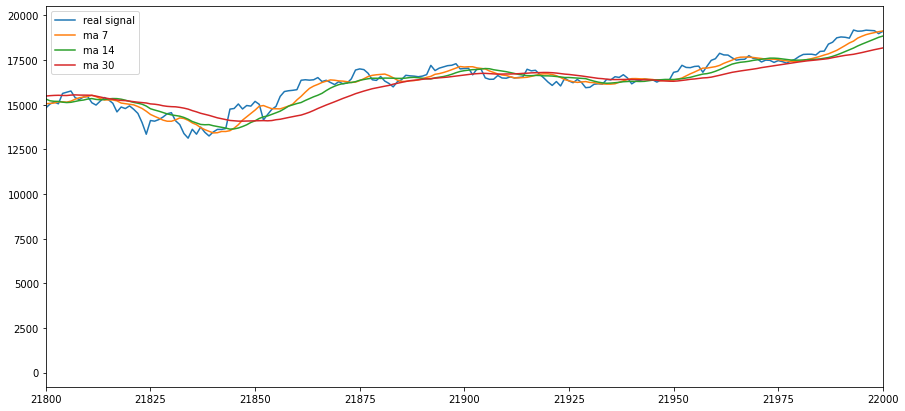

In [21]:
plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(signal)), signal, label = 'real signal')
plt.plot(np.arange(len(signal)), ma_7, label = 'ma 7')
plt.plot(np.arange(len(signal)), ma_14, label = 'ma 14')
plt.plot(np.arange(len(signal)), ma_30, label = 'ma 30')
plt.legend()
plt.xlim(21800,22000)
plt.show()
#plt.savefig('fmogeitjoigt.pdf')

In [70]:
# Can see moving averages just seem to follow the price at a lag

In [22]:
# Normalize
# Note we're dropping Volume here
minmax = MinMaxScaler().fit(
    df[['Close', 'Reddits', 'Tweets']].astype(
        'float32'
    )
)
df_scaled = minmax.transform(
    df[['Close', 'Reddits', 'Tweets']].astype(
        'float32'
    )
)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.head()

,0,1,2
0,0.008619,0.042346,0.000020
1,0.008671,0.041269,0.000024
2,0.008645,0.040768,0.000027
3,0.008651,0.041545,0.000024
4,0.008689,0.042697,0.000027


In [23]:
df_scaled = np.asarray(df_scaled).astype('float32')
df_scaled

array([[8.6189527e-03, 4.2346336e-02, 2.0479842e-05],
       [8.6710807e-03, 4.1268885e-02, 2.3893150e-05],
       [8.6452756e-03, 4.0767744e-02, 2.7306456e-05],
       ...,
       [4.6628234e-01, 4.3047935e-02, 4.1676480e-02],
       [4.6946517e-01, 4.3749530e-02, 1.8861935e-02],
       [4.6753287e-01, 4.3473903e-02, 8.8541182e-03]], dtype=float32)

In [24]:
# Define function to create training matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 2])
    return np.array(dataX), np.array(dataY)

In [25]:
# At this stage its fairly arbitrary, choose to use 80:20 split
training_rows = int(df_scaled.shape[0]*.8)-1
train = df_scaled[:training_rows, :]
test = df_scaled[training_rows:, :]

print(train.shape)
print(test.shape)

(30491, 3)
(7624, 3)


In [26]:
# Re-shape to have matrix
look_back = 10
trainX, trainY = create_dataset(train, look_back)  
testX, testY = create_dataset(test, look_back)

In [27]:
# Re-shape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, 3))
testX = np.reshape(testX, (testX.shape[0],look_back, 3))

In [32]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back,3)))
model.add(layers.Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

model.summary()

history= model.fit(trainX, trainY,validation_split=0.2, epochs=30, batch_size=32)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 128       
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
762/762 [==============================] - 35s 3ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 2/30
762/762 [==============================] - 2s 3ms/step - loss: 9.9799e-04 - val_loss: 0.0024
Epoch 3/30
762/762 [==============================] - 2s 3ms/step - loss: 8.4222e-04 - val_loss: 0.0022
Epoch 4/30
762/762 [==============================] - 2s 3ms/step - loss: 9.8

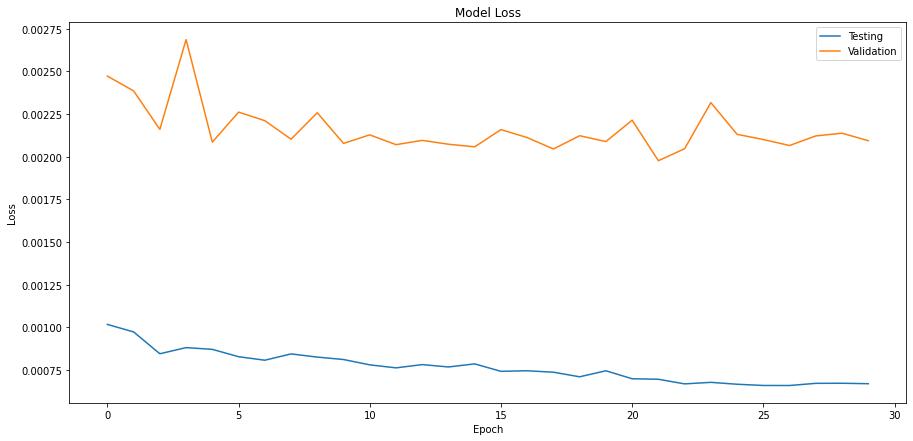

In [33]:
# Plot training
plt.figure(figsize = (15, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Testing', 'Validation'], loc='upper right')
plt.show()